# Indoor Localization

### by [Lorenzo Mario Amorosa](https://github.com/Lostefra)

## Description

This project was developed as *Project Work in Machine Learning - Alma Mater Studiorum Università di Bologna*.

The dataset employed is [UJIIndoorLoc](https://www.researchgate.net/publication/283894296_UJIIndoorLoc_A_new_multi-building_and_multi-floor_database_for_WLAN_fingerprint-based_indoor_localization_problems): a multi-building and multi-floor database for WLAN fingerprint-based indoor localization problems.

## Imports and load dataset

In [1]:
import pandas as pd
import math
import numpy as np
import joblib
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from datetime import datetime
from time import time
from scipy.optimize import minimize
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

tqdm = partial(tqdm, position=0, leave=True)

To download the dataset in colab from github programmatically

In [2]:
!git clone https://github.com/Lostefra/indoor-localization

'git' is not recognized as an internal or external command,
operable program or batch file.


The dataset is loaded and the only columns kept are:
- the WAPs detected at least once
- latitude and longitude
- building, floor, spaceID and relative position to the spaceID.

In [3]:
def read_df(keep_rooms=True):
  if keep_rooms:
    start = 526
    end = -6
  else:
    start = 524
    end = -4
  data1 = 'data/data1.csv'
  data2 = 'data/data2.csv'
  df1 = pd.read_csv(data1)
  df2 = pd.read_csv(data2)
  df = pd.concat([df1, df2], axis=0).reset_index().drop('index', 1)
  df.drop(df.iloc[:, start:], inplace = True, axis = 1)

  to_remove = []
  for column in df.columns.tolist()[:end]:
    never_detected = True
    for rssi in df[column].tolist():
      if rssi <= 0:
        never_detected = False
        break
    if never_detected:
      to_remove.append(column)
  df.drop(to_remove, axis=1, inplace=True)

  return df[:12000]

df = read_df()
print(f'There are {df.shape[0]} entries')
df.head()

C:\Users\yashs\AppData\Local\Temp\ipykernel_9336\3833746491.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.concat([df1, df2], axis=0).reset_index().drop('index', 1)


There are 12000 entries


WAP001  WAP002  WAP005  WAP006  WAP007  WAP008  WAP009  WAP010  WAP011  \
0     100     100     100     100     100     100     100     100     100   
1     100     100     100     100     100     100     100     100     100   
2     100     100     100     100     100     -97     100     100     100   
3     100     100     100     100     100     100     100     100     100   
4     100     100     100     100     100     100     100     100     100   

   WAP012  ...  WAP516  WAP517  WAP518  WAP519  LONGITUDE      LATITUDE  \
0     100  ...     100     100     100     100 -7541.2643  4.864921e+06   
1     100  ...     100     100     100     100 -7536.6212  4.864934e+06   
2     100  ...     100     100     100     100 -7519.1524  4.864950e+06   
3     100  ...     100     100     100     100 -7524.5704  4.864934e+06   
4     100  ...     100     100     100     100 -7632.1436  4.864982e+06   

   FLOOR  BUILDINGID  SPACEID  RELATIVEPOSITION  
0      2           1      106                 2  
1      2           1      106                 2  
2      2           1      103                 2  
3      2           1      102                 2  
4      0           0      122                 2  

[5 rows x 471 columns]

Plot of the most recorded intensity.

In [4]:
counts = {}
for index, row in tqdm(df.iterrows()):
  for column in df.columns.tolist()[:-6]:
    counts[row[column]] = counts.get(row[column], 0) + 1

12000it [00:42, 283.07it/s]


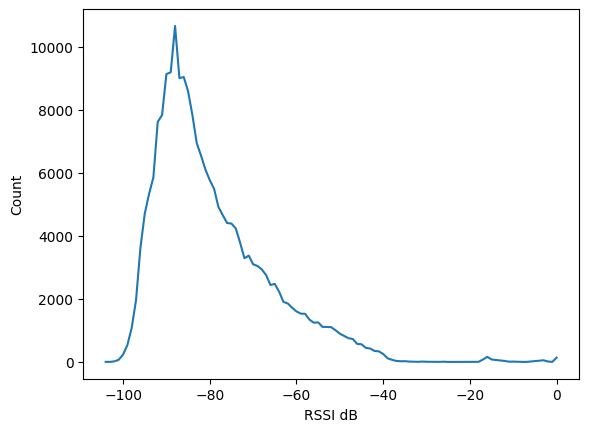

In [5]:
lists = sorted(counts.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x[:-1], y[:-1])
plt.ylabel("Count")
plt.xlabel("RSSI dB")
plt.show()

In [6]:
in_range = 0
tot = 0
start_range = -95
end_range = -73

for k, v in counts.items():
  if k >= start_range and k <= end_range:
    in_range += v
  if k != 100:
    tot += v

percentage_in_range = in_range * 100 / tot
print(f'The {percentage_in_range:.2f}% of non-null detection are in range [{start_range}, {end_range}] dB')

The 72.16% of non-null detection are in range [-95, -73] dB


## Floor and room classification

In this section both the room and the floor of a given record are predicted through machine learning algorithms. Several models are trained using crossvalidation. In the end, the best models are compared using statistical methods.

In [7]:
ts = 0.2
random_state = 42

The `assign_class` function compute the class of a record given the columns regarding its building, floor, spaceID and relative position wrt the spaceID.

In [8]:
def assign_class(row, keep_rooms=True):
  if keep_rooms:
    return str(int(row['BUILDINGID'])) + '-' + str(int(row['FLOOR'])) + '-' + str(int(row['SPACEID'])) + '-' + str(int(row['RELATIVEPOSITION']))
  else:
    return str(int(row['BUILDINGID'])) + '-' + str(int(row['FLOOR']))

The `toInteger` function translate the values of the RSSI to positive integer values.

In [9]:
def toInteger(rssi):
  if rssi > 0:
    return 0
  return rssi + 105

The function `read_df_with_class` returns the dataframe with the classes assigned to each record. The RSSI values are transformed into positive values.

In [10]:
def read_df_with_class(keep_rooms=True):
  df = read_df(keep_rooms=keep_rooms)
  df['class'] = df.apply(lambda row: assign_class(row, keep_rooms=keep_rooms), axis=1)
  if keep_rooms:
    end = -7
  else:
    end = -5
  df_classification = df.iloc[:, :end].applymap(lambda rssi: toInteger(rssi))
  df = pd.concat([df_classification, df.iloc[:, -1:]], axis=1)
  return df

Models definition and related hyperparameters.

In [11]:
# models labels
model_lbls = ['svc','knn','rfc']

# models parameters
tuned_param_svc = [{'kernel': ['rbf'], 
                    'cache_size': [8000], 
                    'gamma': ['scale', 1e-3, 1e-4],
                    'C': [10, 100, 1000]
                    },
                   {'kernel': ['linear'],
                    'cache_size': [8000],
                    'C': [10, 100, 1000]
                    }]
tuned_param_knn =[{'n_neighbors': list(range(1,11)),
                   'metric': ['euclidean', 'manhattan', 'chebyshev']}]
tuned_param_rfc =[{'max_depth': list(range(5,51,5))}]

# models
models = {
    'svc':{'name': 'Support Vector',
           'estimator': SVC(), 
           'param': tuned_param_svc
          },
    'knn':{'name': 'K Nearest Neighbor',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn      
          },
    'rfc':{'name': 'Random Forest',
           'estimator': RandomForestClassifier(),
           'param': tuned_param_rfc
          }
}

scores = ['accuracy', 'f1_macro']

The `print_results` function is an utility to inspect results of parameters search. It returns the accuracy and the f1-macro score of the input model, assessed on the test set.

In [12]:
def print_results(model):
    print("Best parameters set found on train set:\n")
    print(model.best_params_)
    print("\nGrid scores on train set:\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params_tuple))
    print("\nScores for the best parameter set:\n")
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.\n")
    y_true, y_pred = y_test, model.predict(X_test)
    acc, f1 = accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro')
    print(f'Accuracy: {acc:.2f}%')
    print(f'F1-macro: {f1:.2f}%')
    return acc, f1

The `train_and_evaluate` function applies crossvalidation on the previously defined models, tuning the models for both accuracy and f1-macro score. The best models are saved persistently and a dictionary containg the performances of top classifiers is returned.

In [13]:
def train_and_evaluate(X_train, y_train):  
  results_short = {}
  results = {}
  start = time()
  for score in scores:
      print('='*40)
      print("# Tuning hyper-parameters for %s \n" % score)
      for m in model_lbls:
          print('-'*40)
          print(f"Trying model {models[m]['name']}\n")
          # find optimal parameters for the model using grid search (cross validation)
          clf = GridSearchCV(models[m]['estimator'], 
                             models[m]['param'], 
                             cv=3,
                             scoring=score,
                             return_train_score = False,
                             n_jobs = -1, # this allows using multi-cores
                             verbose=0
                             )
          clf.fit(X_train, y_train.values.ravel())
          acc, f1 = print_results(clf)
          results_short[m] = (acc, f1)
          filename = models[m]['name'] + "_" + score + "_" + str(datetime.now().time())[:8] + '.sav'
          # save the model to disk
          # joblib.dump(clf.best_estimator_, filename)
          results[filename[:-13]] = {"accuracy" : acc,
                                     "f1-macro" : f1,
                                     "params" : clf.best_params_}
          # load the model from disk
          # loaded_model = joblib.load(filename)
      # summary of all computed estimators, using their best one param
      print('='*40)
      print(f"Summary of results of models tuned for {score}\n")
      print("Estimator\n")
      for m in results_short.keys():
          print(f"{models[m]['name']}\t - accuracy: {results_short[m][0]:4.2}%")
          print(f"{models[m]['name']}\t - f1-macro: {results_short[m][1]:4.2}%\n")
  end = time()
  print('='*40)
  print(f'train_and_evaluate executed in {end - start} seconds')
  return results

The function `print_evaluation_scores` prints the results obtained by the best models on the test set.

In [14]:
def print_evaluation_scores(results):
  for model, _ in results.items():
    params = ""
    for param_name, v in results[model]["params"].items():
      params += param_name + ": " + str(v) + ", "
    params = params[:-2]
    print("-"*40)
    print(f"{model}\t - accuracy: {results[model]['accuracy']:4.2}% with params=[{params}]")
    print(f"{model}\t - f1-macro: {results[model]['f1-macro']:4.2}% with params=[{params}]\n")

### Predict room

Load dataset.

In [15]:
df = read_df_with_class(keep_rooms=True)
print(f'There are {df["class"].nunique()} unique classes')
df.head()


C:\Users\yashs\AppData\Local\Temp\ipykernel_9336\3833746491.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.concat([df1, df2], axis=0).reset_index().drop('index', 1)


There are 845 unique classes


WAP001  WAP002  WAP005  WAP006  WAP007  WAP008  WAP009  WAP010  WAP011  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       8       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   WAP012  ...  WAP511  WAP512  WAP513  WAP514  WAP515  WAP516  WAP517  \
0       0  ...       0       0       0       0       0       0       0   
1       0  ...       0       0       0       0       0       0       0   
2       0  ...       0       0       0       0       0       0       0   
3       0  ...       0       0       0       0       0       0       0   
4       0  ...       0       0       0       0       0       0       0   

   WAP518  WAP519      class  
0       0       0  1-2-106-2  
1       0       0  1-2-106-2  
2       0       0  1-2-103-2  
3       0       0  1-2-102-2  
4       0       0  0-0-122-2  

[5 rows x 466 columns]

Train-test split.

In [16]:
train, test = train_test_split(df, test_size=ts, random_state=random_state)
X_train, y_train = train.iloc[:, :-1], train.iloc[:, [-1]]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, [-1]]
print(f"Training on {train.shape[0]} samples")
print(f"Testing on {test.shape[0]} samples")

Training on 9600 samples
Testing on 2400 samples


Train and evaluate.

In [17]:
results_predict_room = train_and_evaluate(X_train, y_train)

# Tuning hyper-parameters for accuracy 

----------------------------------------
Trying model Support Vector



C:\Users\yashs\anaconda3\envs\pyproject\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters set found on train set:

{'C': 10, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on train set:

0.796 (+/-0.006) for {'C': 10, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.605 (+/-0.015) for {'C': 10, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.799 (+/-0.011) for {'C': 10, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.797 (+/-0.016) for {'C': 100, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.604 (+/-0.015) for {'C': 100, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.799 (+/-0.016) for {'C': 100, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.796 (+/-0.015) for {'C': 1000, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.605 (+/-0.015) for {'C': 1000, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.798 (+/-0.016) for {'C': 1000, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.785 (+/-0.014) for {'C': 10, 'cache_size': 8000, 'kernel': 'linear'}
0.785 (+/-0.014) for {

C:\Users\yashs\anaconda3\envs\pyproject\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters set found on train set:

{'metric': 'manhattan', 'n_neighbors': 1}

Grid scores on train set:

0.744 (+/-0.009) for {'metric': 'euclidean', 'n_neighbors': 1}
0.707 (+/-0.010) for {'metric': 'euclidean', 'n_neighbors': 2}
0.719 (+/-0.003) for {'metric': 'euclidean', 'n_neighbors': 3}
0.717 (+/-0.008) for {'metric': 'euclidean', 'n_neighbors': 4}
0.712 (+/-0.006) for {'metric': 'euclidean', 'n_neighbors': 5}
0.699 (+/-0.003) for {'metric': 'euclidean', 'n_neighbors': 6}
0.686 (+/-0.009) for {'metric': 'euclidean', 'n_neighbors': 7}
0.670 (+/-0.006) for {'metric': 'euclidean', 'n_neighbors': 8}
0.653 (+/-0.007) for {'metric': 'euclidean', 'n_neighbors': 9}
0.641 (+/-0.013) for {'metric': 'euclidean', 'n_neighbors': 10}
0.793 (+/-0.015) for {'metric': 'manhattan', 'n_neighbors': 1}
0.757 (+/-0.009) for {'metric': 'manhattan', 'n_neighbors': 2}
0.772 (+/-0.018) for {'metric': 'manhattan', 'n_neighbors': 3}
0.767 (+/-0.020) for {'metric': 'manhattan', 'n_neighbors': 4}
0.763 

C:\Users\yashs\anaconda3\envs\pyproject\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters set found on train set:

{'max_depth': 50}

Grid scores on train set:

0.189 (+/-0.008) for {'max_depth': 5}
0.392 (+/-0.005) for {'max_depth': 10}
0.510 (+/-0.017) for {'max_depth': 15}
0.604 (+/-0.018) for {'max_depth': 20}
0.674 (+/-0.015) for {'max_depth': 25}
0.718 (+/-0.019) for {'max_depth': 30}
0.760 (+/-0.014) for {'max_depth': 35}
0.784 (+/-0.017) for {'max_depth': 40}
0.802 (+/-0.005) for {'max_depth': 45}
0.820 (+/-0.009) for {'max_depth': 50}

Scores for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

Accuracy: 0.82%
F1-macro: 0.77%
Summary of results of models tuned for accuracy

Estimator

Support Vector	 - accuracy:  0.8%
Support Vector	 - f1-macro: 0.74%

K Nearest Neighbor	 - accuracy:  0.8%
K Nearest Neighbor	 - f1-macro: 0.73%

Random Forest	 - accuracy: 0.82%
Random Forest	 - f1-macro: 0.77%

# Tuning hyper-parameters for f1_macro 

----------------------------------------
Trying mo

C:\Users\yashs\anaconda3\envs\pyproject\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters set found on train set:

{'C': 100, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on train set:

0.753 (+/-0.006) for {'C': 10, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.575 (+/-0.019) for {'C': 10, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.759 (+/-0.014) for {'C': 10, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.760 (+/-0.018) for {'C': 100, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.574 (+/-0.019) for {'C': 100, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.761 (+/-0.016) for {'C': 100, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.759 (+/-0.017) for {'C': 1000, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.575 (+/-0.020) for {'C': 1000, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.761 (+/-0.016) for {'C': 1000, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.751 (+/-0.014) for {'C': 10, 'cache_size': 8000, 'kernel': 'linear'}
0.751 (+/-0.014) for 

C:\Users\yashs\anaconda3\envs\pyproject\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters set found on train set:

{'metric': 'manhattan', 'n_neighbors': 1}

Grid scores on train set:

0.690 (+/-0.010) for {'metric': 'euclidean', 'n_neighbors': 1}
0.645 (+/-0.015) for {'metric': 'euclidean', 'n_neighbors': 2}
0.662 (+/-0.009) for {'metric': 'euclidean', 'n_neighbors': 3}
0.659 (+/-0.008) for {'metric': 'euclidean', 'n_neighbors': 4}
0.652 (+/-0.010) for {'metric': 'euclidean', 'n_neighbors': 5}
0.634 (+/-0.005) for {'metric': 'euclidean', 'n_neighbors': 6}
0.617 (+/-0.008) for {'metric': 'euclidean', 'n_neighbors': 7}
0.596 (+/-0.008) for {'metric': 'euclidean', 'n_neighbors': 8}
0.574 (+/-0.009) for {'metric': 'euclidean', 'n_neighbors': 9}
0.559 (+/-0.020) for {'metric': 'euclidean', 'n_neighbors': 10}
0.746 (+/-0.020) for {'metric': 'manhattan', 'n_neighbors': 1}
0.702 (+/-0.003) for {'metric': 'manhattan', 'n_neighbors': 2}
0.720 (+/-0.020) for {'metric': 'manhattan', 'n_neighbors': 3}
0.714 (+/-0.024) for {'metric': 'manhattan', 'n_neighbors': 4}
0.710 

C:\Users\yashs\anaconda3\envs\pyproject\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters set found on train set:

{'max_depth': 50}

Grid scores on train set:

0.089 (+/-0.012) for {'max_depth': 5}
0.260 (+/-0.024) for {'max_depth': 10}
0.377 (+/-0.012) for {'max_depth': 15}
0.501 (+/-0.033) for {'max_depth': 20}
0.567 (+/-0.022) for {'max_depth': 25}
0.625 (+/-0.022) for {'max_depth': 30}
0.686 (+/-0.045) for {'max_depth': 35}
0.710 (+/-0.014) for {'max_depth': 40}
0.752 (+/-0.013) for {'max_depth': 45}
0.768 (+/-0.013) for {'max_depth': 50}

Scores for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

Accuracy: 0.83%
F1-macro: 0.77%
Summary of results of models tuned for f1_macro

Estimator

Support Vector	 - accuracy:  0.8%
Support Vector	 - f1-macro: 0.74%

K Nearest Neighbor	 - accuracy:  0.8%
K Nearest Neighbor	 - f1-macro: 0.73%

Random Forest	 - accuracy: 0.83%
Random Forest	 - f1-macro: 0.77%

train_and_evaluate executed in 2480.289183616638 seconds


Print results of best models on test set.

In [18]:
print_evaluation_scores(results_predict_room)

----------------------------------------
Support Vector_accuracy	 - accuracy:  0.8% with params=[C: 10, cache_size: 8000, gamma: 0.0001, kernel: rbf]
Support Vector_accuracy	 - f1-macro: 0.74% with params=[C: 10, cache_size: 8000, gamma: 0.0001, kernel: rbf]

----------------------------------------
K Nearest Neighbor_accuracy	 - accuracy:  0.8% with params=[metric: manhattan, n_neighbors: 1]
K Nearest Neighbor_accuracy	 - f1-macro: 0.73% with params=[metric: manhattan, n_neighbors: 1]

----------------------------------------
Random Forest_accuracy	 - accuracy: 0.82% with params=[max_depth: 50]
Random Forest_accuracy	 - f1-macro: 0.77% with params=[max_depth: 50]

----------------------------------------
Support Vector_f1_macro	 - accuracy:  0.8% with params=[C: 100, cache_size: 8000, gamma: 0.0001, kernel: rbf]
Support Vector_f1_macro	 - f1-macro: 0.74% with params=[C: 100, cache_size: 8000, gamma: 0.0001, kernel: rbf]

----------------------------------------
K Nearest Neighbor_f1_m

### Predict floor

Load dataset.

In [19]:
df = read_df_with_class(keep_rooms=False)
print(f'There are {df["class"].nunique()} unique classes')
df.head()


C:\Users\yashs\AppData\Local\Temp\ipykernel_9336\3833746491.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.concat([df1, df2], axis=0).reset_index().drop('index', 1)


There are 13 unique classes


WAP001  WAP002  WAP005  WAP006  WAP007  WAP008  WAP009  WAP010  WAP011  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       8       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   WAP012  ...  WAP511  WAP512  WAP513  WAP514  WAP515  WAP516  WAP517  \
0       0  ...       0       0       0       0       0       0       0   
1       0  ...       0       0       0       0       0       0       0   
2       0  ...       0       0       0       0       0       0       0   
3       0  ...       0       0       0       0       0       0       0   
4       0  ...       0       0       0       0       0       0       0   

   WAP518  WAP519  class  
0       0       0    1-2  
1       0       0    1-2  
2       0       0    1-2  
3       0       0    1-2  
4       0       0    0-0  

[5 rows x 466 columns]

Train-test split.

In [20]:
train, test = train_test_split(df, test_size=ts, random_state=random_state)
X_train, y_train = train.iloc[:, :-1], train.iloc[:, [-1]]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, [-1]]
print(f"Training on {train.shape[0]} samples")
print(f"Testing on {test.shape[0]} samples")

Training on 9600 samples
Testing on 2400 samples


Train and evaluate.

In [21]:
results_predict_floor = train_and_evaluate(X_train, y_train)

# Tuning hyper-parameters for accuracy 

----------------------------------------
Trying model Support Vector

Best parameters set found on train set:

{'C': 10, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on train set:

0.997 (+/-0.001) for {'C': 10, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.888 (+/-0.010) for {'C': 10, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.997 (+/-0.001) for {'C': 10, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.997 (+/-0.001) for {'C': 100, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.888 (+/-0.010) for {'C': 100, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.997 (+/-0.001) for {'C': 100, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.997 (+/-0.001) for {'C': 1000, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.888 (+/-0.010) for {'C': 1000, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.997 (+/-0.001) for {'C': 1000, 'cache_size': 8000, 'gamma': 0.0001,

Accuracy: 1.00%
F1-macro: 1.00%
----------------------------------------
Trying model Random Forest

Best parameters set found on train set:

{'max_depth': 40}

Grid scores on train set:

0.586 (+/-0.069) for {'max_depth': 5}
0.919 (+/-0.019) for {'max_depth': 10}
0.967 (+/-0.009) for {'max_depth': 15}
0.988 (+/-0.003) for {'max_depth': 20}
0.992 (+/-0.001) for {'max_depth': 25}
0.993 (+/-0.003) for {'max_depth': 30}
0.995 (+/-0.001) for {'max_depth': 35}
0.996 (+/-0.001) for {'max_depth': 40}
0.996 (+/-0.001) for {'max_depth': 45}
0.996 (+/-0.002) for {'max_depth': 50}

Scores for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

Accuracy: 1.00%
F1-macro: 1.00%
Summary of results of models tuned for f1_macro

Estimator

Support Vector	 - accuracy:  1.0%
Support Vector	 - f1-macro:  1.0%

K Nearest Neighbor	 - accuracy:  1.0%
K Nearest Neighbor	 - f1-macro:  1.0%

Random Forest	 - accuracy:  1.0%
Random Forest	 - f1-macr

Print results of best models on test set.

In [22]:
print_evaluation_scores(results_predict_floor)

----------------------------------------
Support Vector_accuracy	 - accuracy:  1.0% with params=[C: 10, cache_size: 8000, gamma: 0.0001, kernel: rbf]
Support Vector_accuracy	 - f1-macro:  1.0% with params=[C: 10, cache_size: 8000, gamma: 0.0001, kernel: rbf]

----------------------------------------
K Nearest Neighbor_accuracy	 - accuracy:  1.0% with params=[metric: manhattan, n_neighbors: 1]
K Nearest Neighbor_accuracy	 - f1-macro:  1.0% with params=[metric: manhattan, n_neighbors: 1]

----------------------------------------
Random Forest_accuracy	 - accuracy:  1.0% with params=[max_depth: 35]
Random Forest_accuracy	 - f1-macro:  1.0% with params=[max_depth: 35]

----------------------------------------
Support Vector_f1_macro	 - accuracy:  1.0% with params=[C: 10, cache_size: 8000, gamma: 0.0001, kernel: rbf]
Support Vector_f1_macro	 - f1-macro:  1.0% with params=[C: 10, cache_size: 8000, gamma: 0.0001, kernel: rbf]

----------------------------------------
K Nearest Neighbor_f1_mac

## Principal Component Analysis (PCA)

In this section Principal Component Analysis (PCA) is applied on the dataset. Many of the recorded values are zeros, therefore a significant dimensionality reduction can be applied, with a negligible loss of information.

The high sparsity of the dataset suggests that PCA can be applied effectively.

In [23]:
zeros = 0
tot = 0
df = read_df_with_class(keep_rooms=False)
for index, row in tqdm(df.iterrows()):
  for column in df.columns.tolist()[:-1]:
    tot += 1
    if row[column] == 0:
      zeros += 1
p = zeros * 100 / tot
print(f'\nThe zero values are the {p:.2f}% of the dataset')

C:\Users\yashs\AppData\Local\Temp\ipykernel_9336\3833746491.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.concat([df1, df2], axis=0).reset_index().drop('index', 1)
12000it [00:21, 570.79it/s]


The zero values are the 96.23% of the dataset


Plot of the cumulative explained variance wrt number of components used.

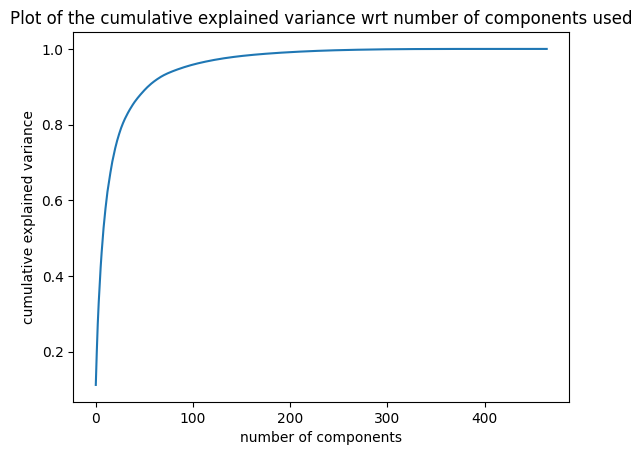

In [24]:
pca = PCA().fit(df.iloc[:, :-1])
plt.title('Plot of the cumulative explained variance wrt number of components used')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Find number of components necessary to explain the 96% of the variance.

In [25]:
for i in range(1, len(df.columns.tolist()) - 1):
  if np.cumsum(pca.explained_variance_ratio_[:i])[-1] > 0.96:
    n_components = i
    break
explained_variance = np.cumsum(pca.explained_variance_ratio_[:i])[-1] * 100
print(f'{explained_variance:.2f}% of the variance explained using {n_components} components')

96.06% of the variance explained using 104 components


### Predict room

Load dataset and train-test split.

In [26]:
df = read_df_with_class(keep_rooms=True)
train, test = train_test_split(df, test_size=ts, random_state=random_state)
X_train, y_train = train.iloc[:, :-1], train.iloc[:, [-1]]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, [-1]]

C:\Users\yashs\AppData\Local\Temp\ipykernel_9336\3833746491.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.concat([df1, df2], axis=0).reset_index().drop('index', 1)


PCA application.

In [27]:
pca = PCA(n_components=n_components)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

Train and evaluate.

In [28]:
results_pca_predict_room = train_and_evaluate(X_train, y_train)

# Tuning hyper-parameters for accuracy 

----------------------------------------
Trying model Support Vector



C:\Users\yashs\anaconda3\envs\pyproject\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters set found on train set:

{'C': 100, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on train set:

0.788 (+/-0.005) for {'C': 10, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.711 (+/-0.017) for {'C': 10, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.793 (+/-0.006) for {'C': 10, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.793 (+/-0.001) for {'C': 100, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.709 (+/-0.017) for {'C': 100, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.795 (+/-0.002) for {'C': 100, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.792 (+/-0.002) for {'C': 1000, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.709 (+/-0.017) for {'C': 1000, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.794 (+/-0.003) for {'C': 1000, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.779 (+/-0.002) for {'C': 10, 'cache_size': 8000, 'kernel': 'linear'}
0.779 (+/-0.003) for 

C:\Users\yashs\anaconda3\envs\pyproject\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters set found on train set:

{'metric': 'euclidean', 'n_neighbors': 1}

Grid scores on train set:

0.757 (+/-0.008) for {'metric': 'euclidean', 'n_neighbors': 1}
0.725 (+/-0.008) for {'metric': 'euclidean', 'n_neighbors': 2}
0.733 (+/-0.015) for {'metric': 'euclidean', 'n_neighbors': 3}
0.722 (+/-0.012) for {'metric': 'euclidean', 'n_neighbors': 4}
0.717 (+/-0.010) for {'metric': 'euclidean', 'n_neighbors': 5}
0.705 (+/-0.007) for {'metric': 'euclidean', 'n_neighbors': 6}
0.696 (+/-0.012) for {'metric': 'euclidean', 'n_neighbors': 7}
0.680 (+/-0.014) for {'metric': 'euclidean', 'n_neighbors': 8}
0.664 (+/-0.008) for {'metric': 'euclidean', 'n_neighbors': 9}
0.646 (+/-0.011) for {'metric': 'euclidean', 'n_neighbors': 10}
0.755 (+/-0.010) for {'metric': 'manhattan', 'n_neighbors': 1}
0.715 (+/-0.015) for {'metric': 'manhattan', 'n_neighbors': 2}
0.728 (+/-0.013) for {'metric': 'manhattan', 'n_neighbors': 3}
0.721 (+/-0.017) for {'metric': 'manhattan', 'n_neighbors': 4}
0.717 

C:\Users\yashs\anaconda3\envs\pyproject\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters set found on train set:

{'max_depth': 45}

Grid scores on train set:

0.244 (+/-0.018) for {'max_depth': 5}
0.491 (+/-0.007) for {'max_depth': 10}
0.634 (+/-0.019) for {'max_depth': 15}
0.702 (+/-0.022) for {'max_depth': 20}
0.738 (+/-0.014) for {'max_depth': 25}
0.753 (+/-0.006) for {'max_depth': 30}
0.763 (+/-0.017) for {'max_depth': 35}
0.763 (+/-0.013) for {'max_depth': 40}
0.764 (+/-0.004) for {'max_depth': 45}
0.763 (+/-0.007) for {'max_depth': 50}

Scores for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

Accuracy: 0.76%
F1-macro: 0.70%
Summary of results of models tuned for accuracy

Estimator

Support Vector	 - accuracy:  0.8%
Support Vector	 - f1-macro: 0.74%

K Nearest Neighbor	 - accuracy: 0.77%
K Nearest Neighbor	 - f1-macro: 0.69%

Random Forest	 - accuracy: 0.76%
Random Forest	 - f1-macro:  0.7%

# Tuning hyper-parameters for f1_macro 

----------------------------------------
Trying mo

C:\Users\yashs\anaconda3\envs\pyproject\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters set found on train set:

{'C': 1000, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on train set:

0.739 (+/-0.004) for {'C': 10, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.675 (+/-0.017) for {'C': 10, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.748 (+/-0.004) for {'C': 10, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.755 (+/-0.011) for {'C': 100, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.675 (+/-0.016) for {'C': 100, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.757 (+/-0.011) for {'C': 100, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.756 (+/-0.009) for {'C': 1000, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.675 (+/-0.016) for {'C': 1000, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.758 (+/-0.008) for {'C': 1000, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.744 (+/-0.004) for {'C': 10, 'cache_size': 8000, 'kernel': 'linear'}
0.745 (+/-0.004) for

C:\Users\yashs\anaconda3\envs\pyproject\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters set found on train set:

{'metric': 'euclidean', 'n_neighbors': 1}

Grid scores on train set:

0.712 (+/-0.017) for {'metric': 'euclidean', 'n_neighbors': 1}
0.672 (+/-0.007) for {'metric': 'euclidean', 'n_neighbors': 2}
0.684 (+/-0.017) for {'metric': 'euclidean', 'n_neighbors': 3}
0.669 (+/-0.010) for {'metric': 'euclidean', 'n_neighbors': 4}
0.663 (+/-0.008) for {'metric': 'euclidean', 'n_neighbors': 5}
0.648 (+/-0.012) for {'metric': 'euclidean', 'n_neighbors': 6}
0.631 (+/-0.016) for {'metric': 'euclidean', 'n_neighbors': 7}
0.614 (+/-0.022) for {'metric': 'euclidean', 'n_neighbors': 8}
0.591 (+/-0.012) for {'metric': 'euclidean', 'n_neighbors': 9}
0.568 (+/-0.014) for {'metric': 'euclidean', 'n_neighbors': 10}
0.709 (+/-0.015) for {'metric': 'manhattan', 'n_neighbors': 1}
0.661 (+/-0.010) for {'metric': 'manhattan', 'n_neighbors': 2}
0.676 (+/-0.011) for {'metric': 'manhattan', 'n_neighbors': 3}
0.668 (+/-0.017) for {'metric': 'manhattan', 'n_neighbors': 4}
0.661 

C:\Users\yashs\anaconda3\envs\pyproject\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters set found on train set:

{'max_depth': 50}

Grid scores on train set:

0.117 (+/-0.004) for {'max_depth': 5}
0.365 (+/-0.025) for {'max_depth': 10}
0.537 (+/-0.011) for {'max_depth': 15}
0.633 (+/-0.014) for {'max_depth': 20}
0.680 (+/-0.021) for {'max_depth': 25}
0.692 (+/-0.006) for {'max_depth': 30}
0.708 (+/-0.009) for {'max_depth': 35}
0.718 (+/-0.008) for {'max_depth': 40}
0.717 (+/-0.012) for {'max_depth': 45}
0.719 (+/-0.005) for {'max_depth': 50}

Scores for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

Accuracy: 0.77%
F1-macro: 0.71%
Summary of results of models tuned for f1_macro

Estimator

Support Vector	 - accuracy:  0.8%
Support Vector	 - f1-macro: 0.74%

K Nearest Neighbor	 - accuracy: 0.77%
K Nearest Neighbor	 - f1-macro: 0.69%

Random Forest	 - accuracy: 0.77%
Random Forest	 - f1-macro: 0.71%

train_and_evaluate executed in 5085.844000577927 seconds


Print results of best models on test set.

In [29]:
print_evaluation_scores(results_pca_predict_room)

----------------------------------------
Support Vector_accuracy	 - accuracy:  0.8% with params=[C: 100, cache_size: 8000, gamma: 0.0001, kernel: rbf]
Support Vector_accuracy	 - f1-macro: 0.74% with params=[C: 100, cache_size: 8000, gamma: 0.0001, kernel: rbf]

----------------------------------------
K Nearest Neighbor_accuracy	 - accuracy: 0.77% with params=[metric: euclidean, n_neighbors: 1]
K Nearest Neighbor_accuracy	 - f1-macro: 0.69% with params=[metric: euclidean, n_neighbors: 1]

----------------------------------------
Random Forest_accuracy	 - accuracy: 0.76% with params=[max_depth: 45]
Random Forest_accuracy	 - f1-macro:  0.7% with params=[max_depth: 45]

----------------------------------------
Support Vector_f1_macro	 - accuracy:  0.8% with params=[C: 1000, cache_size: 8000, gamma: 0.0001, kernel: rbf]
Support Vector_f1_macro	 - f1-macro: 0.74% with params=[C: 1000, cache_size: 8000, gamma: 0.0001, kernel: rbf]

----------------------------------------
K Nearest Neighbor_

### Predict floor

Load dataset and train-test split.

In [30]:
df = read_df_with_class(keep_rooms=False)
train, test = train_test_split(df, test_size=ts, random_state=random_state)
X_train, y_train = train.iloc[:, :-1], train.iloc[:, [-1]]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, [-1]]

C:\Users\yashs\AppData\Local\Temp\ipykernel_9336\3833746491.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.concat([df1, df2], axis=0).reset_index().drop('index', 1)


PCA application.

In [31]:
pca = PCA(n_components=n_components)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

Train and evaluate.

In [32]:
results_pca_predict_floor = train_and_evaluate(X_train, y_train)

# Tuning hyper-parameters for accuracy 

----------------------------------------
Trying model Support Vector

Best parameters set found on train set:

{'C': 10, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on train set:

0.997 (+/-0.000) for {'C': 10, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.955 (+/-0.008) for {'C': 10, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.997 (+/-0.001) for {'C': 10, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.997 (+/-0.000) for {'C': 100, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.955 (+/-0.008) for {'C': 100, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.997 (+/-0.001) for {'C': 100, 'cache_size': 8000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.997 (+/-0.000) for {'C': 1000, 'cache_size': 8000, 'gamma': 'scale', 'kernel': 'rbf'}
0.955 (+/-0.008) for {'C': 1000, 'cache_size': 8000, 'gamma': 0.001, 'kernel': 'rbf'}
0.997 (+/-0.000) for {'C': 1000, 'cache_size': 8000, 'gamma': 0.0001,

Best parameters set found on train set:

{'max_depth': 50}

Grid scores on train set:

0.945 (+/-0.010) for {'max_depth': 5}
0.993 (+/-0.002) for {'max_depth': 10}
0.995 (+/-0.001) for {'max_depth': 15}
0.995 (+/-0.001) for {'max_depth': 20}
0.994 (+/-0.001) for {'max_depth': 25}
0.994 (+/-0.001) for {'max_depth': 30}
0.996 (+/-0.001) for {'max_depth': 35}
0.995 (+/-0.002) for {'max_depth': 40}
0.995 (+/-0.001) for {'max_depth': 45}
0.996 (+/-0.000) for {'max_depth': 50}

Scores for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

Accuracy: 1.00%
F1-macro: 0.99%
Summary of results of models tuned for f1_macro

Estimator

Support Vector	 - accuracy:  1.0%
Support Vector	 - f1-macro:  1.0%

K Nearest Neighbor	 - accuracy:  1.0%
K Nearest Neighbor	 - f1-macro:  1.0%

Random Forest	 - accuracy:  1.0%
Random Forest	 - f1-macro: 0.99%

train_and_evaluate executed in 394.5008580684662 seconds


Print results of best models on test set.

In [33]:
print_evaluation_scores(results_pca_predict_floor)

----------------------------------------
Support Vector_accuracy	 - accuracy:  1.0% with params=[C: 10, cache_size: 8000, gamma: 0.0001, kernel: rbf]
Support Vector_accuracy	 - f1-macro:  1.0% with params=[C: 10, cache_size: 8000, gamma: 0.0001, kernel: rbf]

----------------------------------------
K Nearest Neighbor_accuracy	 - accuracy:  1.0% with params=[metric: euclidean, n_neighbors: 1]
K Nearest Neighbor_accuracy	 - f1-macro:  1.0% with params=[metric: euclidean, n_neighbors: 1]

----------------------------------------
Random Forest_accuracy	 - accuracy: 0.99% with params=[max_depth: 20]
Random Forest_accuracy	 - f1-macro: 0.99% with params=[max_depth: 20]

----------------------------------------
Support Vector_f1_macro	 - accuracy:  1.0% with params=[C: 10, cache_size: 8000, gamma: 0.0001, kernel: rbf]
Support Vector_f1_macro	 - f1-macro:  1.0% with params=[C: 10, cache_size: 8000, gamma: 0.0001, kernel: rbf]

----------------------------------------
K Nearest Neighbor_f1_mac

## Models comparison

In this section the best models are compared in order to see whether there is a statistical significant difference between them. Notice that it happens that a model's best hyperparameters can be the same both for accuracy and f1-macro tuning, consequently only one version of the model is kept.

The function `get_best_model` return the name, accuracy and f1-macro score for the model that obtain the best result for a given metric (accuracy by default). 


In [34]:
def get_best_model(results, metric="accuracy"):
  best = {"name" : "empty", "accuracy" : 0, "f1-macro" : 0}
  for model, _ in results.items():
    if results[model][metric] > best[metric]:
      best = {"name" : model, "accuracy" : results[model]["accuracy"], "f1-macro" : results[model]["f1-macro"]}
  if metric == "f1-macro":
    best["name"] = best["name"].replace("accuracy", "f1-macro")
  return best

Determines whether the difference in the input metric of models A and B is statistically significant. The reasoning behind the algorithm can be found [here](https://github.com/Lostefra/indoor-localization/blob/main/slides/statistical_model_comparison.pdf).
- `metricA`, `metricB` [double]: metric of the two models
- `nA`, `nB` [int]: number of samples of the two models
- `conf` [float, default 0.95]: confidence
- `modelA`, `modelB` [string]: name of the models

In [35]:
confidence = 0.9
N = test.shape[0]

In [36]:
def models_comparison(metricA, metricB, nA, nB, modelA, modelB, conf = .95, verbose = False):
  # If the two models are the same or are already compared then avoid comparison
  if modelA[:-8] == modelB[:-8] or (modelA[:-8], modelB[:-8]) in already_compared:
    return
  already_compared.append((modelA[:-8], modelB[:-8]))
  if verbose:
    print("Confidence: {:.1%}".format(conf))
  
  alpha = 1 - conf 
  z = np.absolute(stats.norm.ppf(alpha / 2)) # Two tails
  # Models error
  eA = 1 - metricA
  eB = 1 - metricB
  # Error difference estimation
  d = np.absolute(eA - eB)
  # Difference interval
  sigma_d = np.sqrt((eA * metricA) / nA + (eB * metricB) / nB)
  d_min = d - z * sigma_d
  d_max = d + z * sigma_d

  if d_min <= 0 and d_max >= 0:
    if verbose:
      print("Interval: [{:.3f}, {:.3f}]".format(d_min, d_max))
    print(f"There is NO statistical difference between the models \"{modelA}\" and \"{modelB}\"")
  else:
    if verbose:
      print("Interval: [{:.3f}, {:.3f}]".format(d_min, d_max))
    if metricA > metricB:
      print(f"There is a statistical difference between the models \"{modelA}\" and \"{modelB}\": \"{modelA}\" is better")
    else:
      print(f"There is a statistical difference between the models \"{modelA}\" and \"{modelB}\": \"{modelB}\" is better")

### Predict room

Get best models.

In [37]:
best_accuracy_room = get_best_model(results_predict_room, metric="accuracy")
best_f1_macro_room = get_best_model(results_predict_room, metric="f1-macro")
best_pca_accuracy_room = get_best_model(results_pca_predict_room, metric="accuracy")
best_pca_f1_macro_room = get_best_model(results_pca_predict_room, metric="f1-macro")

Compare models.

In [38]:
for metric in ["accuracy", "f1-macro"]:
  print("-"*40)
  print(f"Comparing models by {metric}")
  already_compared = []
  models_comparison(best_accuracy_room[metric], best_f1_macro_room[metric], N, N, best_accuracy_room["name"], best_f1_macro_room["name"], conf = confidence)
  models_comparison(best_accuracy_room[metric], best_pca_accuracy_room[metric], N, N, best_accuracy_room["name"], "PCA_" + best_pca_accuracy_room["name"], conf = confidence)
  models_comparison(best_accuracy_room[metric], best_pca_f1_macro_room[metric], N, N, best_accuracy_room["name"], "PCA_" + best_pca_f1_macro_room["name"], conf = confidence)

  models_comparison(best_f1_macro_room[metric], best_pca_accuracy_room[metric], N, N, best_f1_macro_room["name"], "PCA_" + best_pca_accuracy_room["name"], conf = confidence)
  models_comparison(best_f1_macro_room[metric], best_pca_f1_macro_room[metric], N, N, best_f1_macro_room["name"], "PCA_" + best_pca_f1_macro_room["name"], conf = confidence)

  models_comparison(best_pca_accuracy_room[metric], best_pca_f1_macro_room[metric], N, N, "PCA_" + best_pca_accuracy_room["name"], "PCA_" + best_pca_f1_macro_room["name"], conf = confidence)

----------------------------------------
Comparing models by accuracy
There is a statistical difference between the models "Random Forest_f1_macro" and "PCA_Support Vector_f1_macro": "Random Forest_f1_macro" is better
----------------------------------------
Comparing models by f1-macro
There is a statistical difference between the models "Random Forest_f1_macro" and "PCA_Support Vector_f1_macro": "Random Forest_f1_macro" is better


### Predict floor

Get best models.

In [39]:
best_accuracy_floor = get_best_model(results_predict_floor, metric="accuracy")
best_f1_macro_floor = get_best_model(results_predict_floor, metric="f1-macro")
best_pca_accuracy_floor = get_best_model(results_pca_predict_floor, metric="accuracy")
best_pca_f1_macro_floor = get_best_model(results_pca_predict_floor, metric="f1-macro")

Compare models.

In [40]:
for metric in ["accuracy", "f1-macro"]:
  print("-"*40)
  print(f"Comparing models by {metric}")
  already_compared = []
  models_comparison(best_accuracy_floor[metric], best_f1_macro_floor[metric], N, N, best_accuracy_floor["name"], best_f1_macro_floor["name"], conf = confidence)
  models_comparison(best_accuracy_floor[metric], best_pca_accuracy_floor[metric], N, N, best_accuracy_floor["name"], "PCA_" + best_pca_accuracy_floor["name"], conf = confidence)
  models_comparison(best_accuracy_floor[metric], best_pca_f1_macro_floor[metric], N, N, best_accuracy_floor["name"], "PCA_" + best_pca_f1_macro_floor["name"], conf = confidence)
  
  models_comparison(best_f1_macro_floor[metric], best_pca_accuracy_floor[metric], N, N, best_f1_macro_floor["name"], "PCA_" + best_pca_accuracy_floor["name"], conf = confidence)
  models_comparison(best_f1_macro_floor[metric], best_pca_f1_macro_floor[metric], N, N, best_f1_macro_floor["name"], "PCA_" + best_pca_f1_macro_floor["name"], conf = confidence)
  
  models_comparison(best_pca_accuracy_floor[metric], best_pca_f1_macro_floor[metric], N, N, "PCA_" + best_pca_accuracy_floor["name"], "PCA_" + best_pca_f1_macro_floor["name"], conf = confidence)

----------------------------------------
Comparing models by accuracy
There is NO statistical difference between the models "Support Vector_accuracy" and "PCA_Support Vector_accuracy"
----------------------------------------
Comparing models by f1-macro
There is NO statistical difference between the models "Support Vector_accuracy" and "PCA_Support Vector_accuracy"


## WAPs positions estimation via trilateration

In this section it is addressed the problem of computing the coordinates (latitude, longitude) of the WAPs. The method employed is [trilateration](https://en.wikipedia.org/wiki/True-range_multilateration), in particular the solution to the mathematical formulation is provided through an optimization method.  

`utmToLatLng` is a function that returns the latitude and longitude from utm coordinates (given in the dataset).

In [41]:
def utmToLatLng(easting, northing, zone=32, northernHemisphere=True):
    if not northernHemisphere:
        northing = 10000000 - northing

    a = 6378137
    e = 0.081819191
    e1sq = 0.006739497
    k0 = 0.9996
    dlo = -2.763822175537249
    dla = -3.7685847499353073

    arc = northing / k0
    mu = arc / (a * (1 - math.pow(e, 2) / 4.0 - 3 * math.pow(e, 4) / 64.0 - 5 * math.pow(e, 6) / 256.0))

    ei = (1 - math.pow((1 - e * e), (1 / 2.0))) / (1 + math.pow((1 - e * e), (1 / 2.0)))

    ca = 3 * ei / 2 - 27 * math.pow(ei, 3) / 32.0

    cb = 21 * math.pow(ei, 2) / 16 - 55 * math.pow(ei, 4) / 32
    cc = 151 * math.pow(ei, 3) / 96
    cd = 1097 * math.pow(ei, 4) / 512
    phi1 = mu + ca * math.sin(2 * mu) + cb * math.sin(4 * mu) + cc * math.sin(6 * mu) + cd * math.sin(8 * mu)

    n0 = a / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (1 / 2.0))

    r0 = a * (1 - e * e) / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (3 / 2.0))
    fact1 = n0 * math.tan(phi1) / r0

    _a1 = 500000 - easting
    dd0 = _a1 / (n0 * k0)
    fact2 = dd0 * dd0 / 2

    t0 = math.pow(math.tan(phi1), 2)
    Q0 = e1sq * math.pow(math.cos(phi1), 2)
    fact3 = (5 + 3 * t0 + 10 * Q0 - 4 * Q0 * Q0 - 9 * e1sq) * math.pow(dd0, 4) / 24

    fact4 = (61 + 90 * t0 + 298 * Q0 + 45 * t0 * t0 - 252 * e1sq - 3 * Q0 * Q0) * math.pow(dd0, 6) / 720

    lof1 = _a1 / (n0 * k0)
    lof2 = (1 + 2 * t0 + Q0) * math.pow(dd0, 3) / 6.0
    lof3 = (5 - 2 * Q0 + 28 * t0 - 3 * math.pow(Q0, 2) + 8 * e1sq + 24 * math.pow(t0, 2)) * math.pow(dd0, 5) / 120
    _a2 = (lof1 - lof2 + lof3) / math.cos(phi1)
    _a3 = _a2 * 180 / math.pi

    latitude = (180 * (phi1 - fact1 * (fact2 + fact3 + fact4)) / math.pi) + dla

    if not northernHemisphere:
        latitude = -latitude

    longitude = (((zone > 0) and (6 * zone - 183.0) or 3.0) - _a3) + dlo

    return (latitude, longitude)

`getRange` is a function that returns the distance in meters from the received signal strength indicator (RSSI), according to [this reasoning](https://stackoverflow.com/questions/20416218/understanding-ibeacon-distancing/21617601#21617601).

In [42]:
def getRange(rssi):
  if rssi > 0:
    return -1.0
  txCalibratedPower = -65
  ratio_db = txCalibratedPower - rssi;
  ratio_linear = math.pow(10, ratio_db / 10);
  r = math.sqrt(ratio_linear);
  return r;

Plot of the `getRange` function.

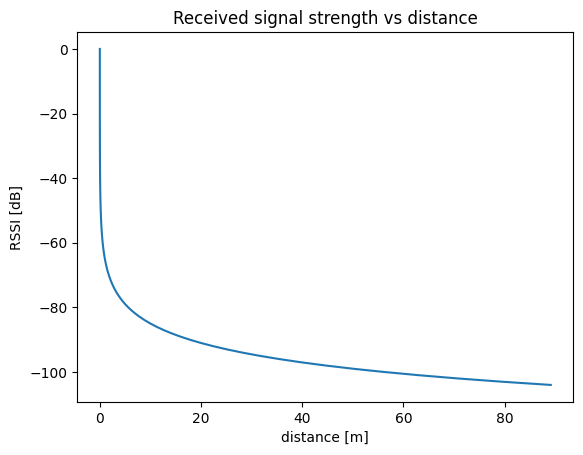

In [43]:
plt.title('Received signal strength vs distance')
plt.plot([getRange(rssi) for rssi in range(0, -105, -1)], list(range(0, -105, -1)))
plt.xlabel('distance [m]')
plt.ylabel('RSSI [dB]');

The function `mse` computes the mean square error between a point `x` and a set of `locations`. The higher is the difference between the expected distances and the computed distances, the higher is the mse.

In [44]:
def euclidean_distance(x1, y1, x2, y2):
  p1 = np.array((x1 ,y1))
  p2 = np.array((x2, y2))
  return np.linalg.norm(p1 - p2)

# Mean Square Error
# locations: [ (lat1, long1), ... ]
# distances: [ distance1, ... ]
def mse(x, locations, distances):
  mse = 0.0
  for location, distance in zip(locations, distances):
      distance_calculated = euclidean_distance(x[0], x[1], location[0], location[1])
      mse += math.pow(distance_calculated - distance, 2.0)
  return mse / len(distances)

The `find_wap` function tries to find the best point x such that the distances between x and the set of input locations is equal to the set of the input distances. The optimization is performed through the `minimize` function of the `scipy.optimize` library.

In [45]:
# locations: [ (lat1, long1), ... ]
# distances: [ distance1,     ... ]
def find_wap(locations, distances):
  initial_location = np.mean(locations, axis=0) # Initial guess is centroid of devices
  result = minimize(
    mse,                         # The error function
    initial_location,            # The initial guess
    args=(locations, distances), # Additional parameters for mse
    method='L-BFGS-B',           # The optimisation algorithm
    options={
        'ftol':1e-5,         # Tolerance
        'maxiter': 1e+7      # Maximum iterations
    }
  )
  lat, lon = tuple(result.x)
  return utmToLatLng(lon, lat)

The `get_distances` function is an utility that packs the information regarding a device record (distance from WAP, device longitude, device latitude) into a tuple of lists of the form `(distances, locations)`.

In [46]:
def get_distances(wap_distances, longitude, latitude):
  distances = []
  locations = []
  for index, d in enumerate(wap_distances):
    if d > 0:
      distances.append(d)
      locations.append((latitude.tolist()[index], longitude.tolist()[index]))
  return (distances, locations)

Load dataset and transform RSSI into distances.

In [47]:
df = read_df()
df.drop(df.iloc[:, -4:], inplace = True, axis = 1)
df_distances = df.iloc[:, :-2].applymap(lambda rssi: getRange(rssi))
df_final = pd.concat([df_distances, df.iloc[:, -2:]], axis=1)
df_final.head()

C:\Users\yashs\AppData\Local\Temp\ipykernel_9336\3833746491.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.concat([df1, df2], axis=0).reset_index().drop('index', 1)


WAP001  WAP002  WAP005  WAP006  WAP007     WAP008  WAP009  WAP010  WAP011  \
0    -1.0    -1.0    -1.0    -1.0    -1.0  -1.000000    -1.0    -1.0    -1.0   
1    -1.0    -1.0    -1.0    -1.0    -1.0  -1.000000    -1.0    -1.0    -1.0   
2    -1.0    -1.0    -1.0    -1.0    -1.0  39.810717    -1.0    -1.0    -1.0   
3    -1.0    -1.0    -1.0    -1.0    -1.0  -1.000000    -1.0    -1.0    -1.0   
4    -1.0    -1.0    -1.0    -1.0    -1.0  -1.000000    -1.0    -1.0    -1.0   

   WAP012  ...  WAP512  WAP513  WAP514  WAP515  WAP516  WAP517  WAP518  \
0    -1.0  ...    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
1    -1.0  ...    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
2    -1.0  ...    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
3    -1.0  ...    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   
4    -1.0  ...    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0    -1.0   

   WAP519  LONGITUDE      LATITUDE  
0    -1.0 -7541.2643  4.864921e+06  
1    -1.0 -7536.6212  4.864934e+06  
2    -1.0 -7519.1524  4.864950e+06  
3    -1.0 -7524.5704  4.864934e+06  
4    -1.0 -7632.1436  4.864982e+06  

[5 rows x 467 columns]

Compute the WAPs locations.

In [48]:
wap_locations = {}
for column in tqdm(df_final.columns.tolist()[:-2]):
  distances, locations = get_distances(df_final[column], df_final["LONGITUDE"], df_final["LATITUDE"])
  if distances:
    wap_location = find_wap(locations, distances)
    wap_locations[column] = wap_location
print("\nWAPs locations:")
wap_locations

100%|████████████████████████████████████████████████████████████████████████████████| 465/465 [01:58<00:00,  3.94it/s]


WAPs locations:


{'WAP001': (39.993906073247445, -0.0696865398430262),
 'WAP005': (39.99218386901932, -0.06547839135116007),
 'WAP006': (39.99275165697644, -0.06722589396827416),
 'WAP007': (39.993059932202655, -0.07011072651270656),
 'WAP008': (39.99342494239275, -0.06871548562519614),
 'WAP009': (39.99324356245053, -0.0701105898303025),
 'WAP010': (39.992512034524665, -0.06799161474955184),
 'WAP011': (39.99245414597967, -0.06652651917953367),
 'WAP012': (39.99245236417214, -0.06651849910601904),
 'WAP013': (39.99312871139091, -0.07011349299278624),
 'WAP014': (39.993128582583296, -0.07011232951656243),
 'WAP015': (39.99257734361122, -0.06818327670397117),
 'WAP016': (39.992569702968005, -0.06818571410815366),
 'WAP017': (39.99348060067744, -0.06929800580028367),
 'WAP018': (39.99379788550167, -0.06966703962700915),
 'WAP019': (39.9933803364138, -0.06998110195068818),
 'WAP020': (39.99338144682004, -0.06998124101205239),
 'WAP021': (39.992662461681356, -0.0681499002573398),
 'WAP022': (39.99260476128

Save WAPs locations to file.

In [49]:
wap_locations_list = []
for k, v in wap_locations.items():
  wap_locations_list.append((k, v[0], v[1]))

with open('wap.csv','w') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(['wap','lat', 'long'])
    for row in wap_locations_list:
        csv_out.writerow(row)

In the following image it is possible to visualize where the inferred positions are. Notice that the records of the dataset are taken only in the 3 right most buildings, but many access points in a fourth building (the left most one) were recorded.

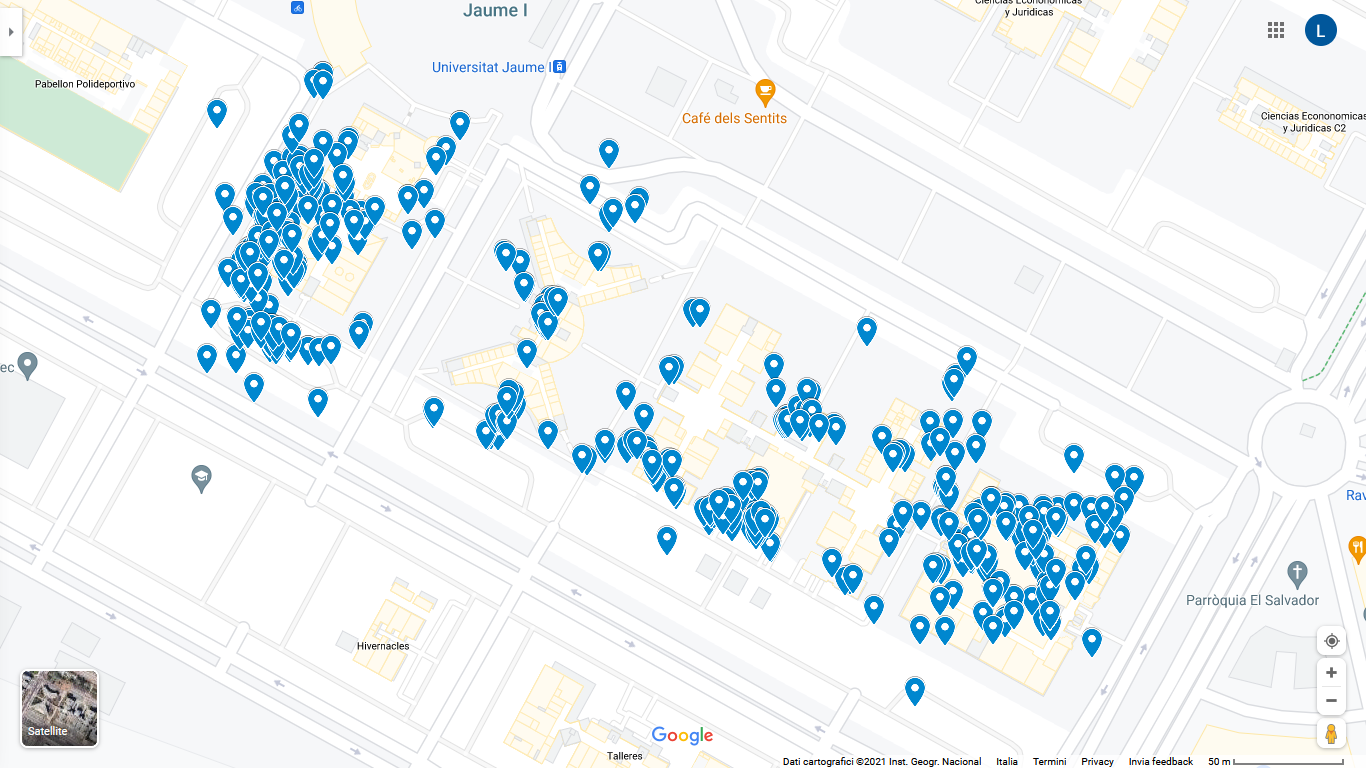

## WAPs coverage analysis

In this section the WAPs reciprocal coverage is analysed through Spearman's correlation. The WAPs that correlated with the highest number of WAPs are highlighted.

The null hypothesis (i.e. two sets of data are not correlated) can be rejected with a confidence = 1 - pvalue, so the higher the pvalue, the higher the probability that two sets of data are not correlated.

For instance, with a pvalue of 0.1, we can assert that the two sets of data are correlated with confidence of 90%.

Three values in both sets are need to obtain both pvalue and correlation with Spearman's method.

The `wap_correlation` function computes the Spearman's correlation between two input WAPs. Only those records where at least one WAP is non null are taken into account for the correlation test.

In [50]:
def wap_correlation(wap_A, wap_B):
  set_A = []
  set_B = []
  for index in range(wap_A.size):
    if not wap_A[index] == 0 and not wap_B[index] == 0:
      set_A.append(wap_A[index])
      set_B.append(wap_B[index])
  return stats.spearmanr(set_A, set_B)

The correlation test is computed pairwise for all the WAPs.

In [51]:
df = read_df_with_class(keep_rooms=False)
column_list = df.columns.tolist()
n_columns = len(column_list)
correlated_wap = []

for i in tqdm(range(n_columns - 2)):
  for j in range(i + 1, n_columns - 1):
    correlation, pvalue = wap_correlation(df[column_list[i]], df[column_list[j]])
    correlated_wap.append((column_list[i], column_list[j], pvalue, correlation))

C:\Users\yashs\AppData\Local\Temp\ipykernel_9336\3833746491.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.concat([df1, df2], axis=0).reset_index().drop('index', 1)
  0%|                                                                                          | 0/464 [00:00<?, ?it/s]C:\Users\yashs\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\yashs\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████████████████████████████████████████████████████████████████████████| 464/464 [1:07:49<00:00,  8.77s/it]


The `pvalue` is low (in this case under 1%) if the two WAPs are correlated. The `correlation` is positive if the increase of the first WAP provokes the increase of the other. Here we count the number of times where every WAP is recognized as correlated to another one.

In [52]:
wap_bad_coverage = {}
for wap_i, wap_j, pvalue, correlation in correlated_wap:
  if pvalue < 0.01 and correlation > 0:
     wap_bad_coverage[wap_i] = wap_bad_coverage.get(wap_i, 0) + 1
     wap_bad_coverage[wap_j] = wap_bad_coverage.get(wap_j, 0) + 1

Save `wap_bad_coverage` to csv.

In [53]:
with open('bad_wap.csv','w') as out:
  print("WAPs whose coverage overlaps with the ones of other WAPs mostly:")
  csv_out = csv.writer(out)
  csv_out.writerow(['wap','count','lat', 'long'])

  for wap, count in wap_bad_coverage.items():
    if count > 50:
      print(f'{wap}: {count} times')
      row = [wap, count, wap_locations[wap][0], wap_locations[wap][1]]
      csv_out.writerow(row)

WAPs whose coverage overlaps with the ones of other WAPs mostly:
WAP502: 51 times
WAP175: 55 times
WAP248: 88 times
WAP165: 57 times
WAP174: 58 times
WAP186: 53 times
WAP187: 59 times
WAP314: 53 times
WAP317: 52 times
WAP078: 64 times
WAP282: 52 times
WAP077: 54 times
WAP284: 57 times
WAP340: 53 times
WAP069: 51 times
WAP070: 60 times
WAP087: 63 times
WAP164: 61 times


The WAPs with the worst coverage are shown below.

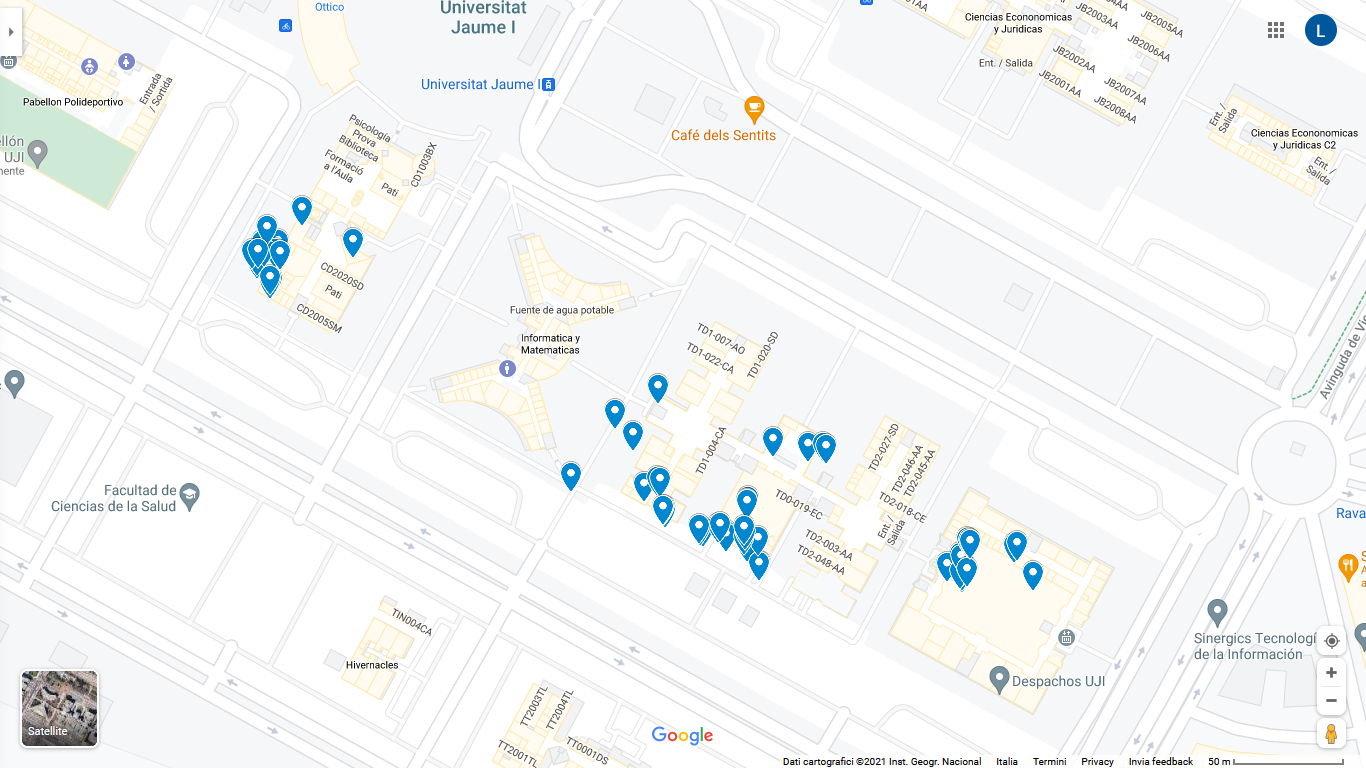